In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psis
%matplotlib inline

In [2]:
lp_samples = pd.read_excel('results.xlsx', sheet_name='Log posterior samples')

In [3]:
lp_samples.shape

(2000, 4400)

In [4]:
data = pd.read_csv('data/MemRL_BIAC_fMRItest_05.05.15_FINALdata_cleaned.csv')

In [5]:
data['Task Condition'] = pd.Categorical.from_codes(data['DelayCond'] - 1, categories=['Immediate', 'Delayed'])
data['Group'] = pd.Categorical.from_codes(data['AgeGroup'] - 1, categories=['Younger Adults', 'Older Adults'])
data.shape

(4400, 11)

In [6]:
data.head()

,SubjNum,AgeGroup,TrialNum,RunNum,DelayCond,Outcome,Chosen,Unchosen,Trial,Task Condition,Group
0,1,1,1,1,1,1.0,6.0,7,1,Immediate,Younger Adults
1,1,1,2,1,1,0.0,7.0,6,2,Immediate,Younger Adults
2,1,1,3,1,2,0.0,5.0,3,3,Delayed,Younger Adults
3,1,1,4,1,1,1.0,7.0,6,4,Immediate,Younger Adults
4,1,1,5,1,1,0.0,7.0,6,5,Immediate,Younger Adults


Now drop rows in `data` and `lp_samples` corresponding to missing trials (no choice made):

In [7]:
data = data.dropna()
data.shape

(4330, 11)

In [8]:
lp_samples = lp_samples.dropna(axis=1)
lp_samples.shape

(2000, 4330)

# Model comparison

Estimate log predicted probability, $\log p(y_{\mathrm{new}}|y_{\mathrm{observed}})$, on new data via leave one out (LOO) cross-validation. Uses the method of [Vehtari, Gelman, and Gabry](http://www.stat.columbia.edu/~gelman/research/unpublished/loo_stan.pdf) as implemented [in this code](https://github.com/avehtari/PSIS). 

The code returns the LOO estimate for each data point, which is a measure of how likely we expect each observation to be under a model trained using all other data. We'll examine how these estimates differ between age groups and conditions.

In [9]:
loo = psis.psisloo(lp_samples.values)

data['loo'] = loo[1]

Make a plot. Error bars are bootstrapped 95% confidence intervals.

/Users/jmxp/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


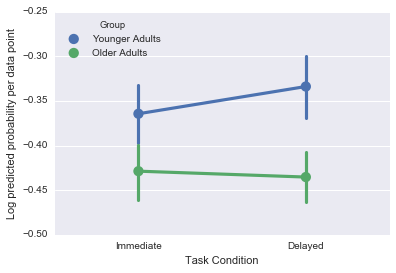

In [10]:
ax = sns.pointplot(data=data, hue='Group', y='loo', x='Task Condition')
plt.ylabel('Log predicted probability per data point');

# Predictive probability

Log probabilities are hard to reason about. Here, we translate the average log probability into a probability. (**Note:** this is not the same as the average predicted probability. With logs and averages, order matters.)

In [11]:
np.exp(data.groupby(['Group', 'Task Condition'])['loo'].mean()).reset_index()

,Group,Task Condition,loo
0,Younger Adults,Immediate,0.694611
1,Younger Adults,Delayed,0.716119
2,Older Adults,Immediate,0.651337
3,Older Adults,Delayed,0.647055


# Tests

Test for differences in the LOO value across groups, conditions.

In [12]:
import scipy.stats as stats

In [13]:
def bootci(arr, n_samples=1000, ci=0.95):
    # assumes arr is 1d
    N = arr.size
    samples = np.random.choice(arr, (n_samples, N))
    means = np.mean(samples, axis=1)
    sorted_means = np.sort(means)
    half_alpha = (1 - ci)/2
    lower_ind = int(np.floor(half_alpha * n_samples))
    upper_ind = int(np.ceil((1 - half_alpha) * n_samples))
    
    tup = (np.mean(arr), (sorted_means[lower_ind], sorted_means[upper_ind]))
    print("Mean: {:.3f}, {:.0f}% CI: ({:.3f}, {:.3f})".format(tup[0], ci * 100, tup[1][0], tup[1][1]))
    
    return tup

In [14]:
bootci(data.loc[data.AgeGroup == 1, 'loo']);
bootci(data.loc[data.AgeGroup == 2, 'loo']);
stats.mannwhitneyu(data.loc[data.AgeGroup == 1, 'loo'], 
                   data.loc[data.AgeGroup == 2, 'loo'])

Mean: -0.349, 95% CI: (-0.376, -0.324)
Mean: -0.432, 95% CI: (-0.453, -0.409)


MannwhitneyuResult(statistic=1931873.0, pvalue=2.2728583343306998e-23)

In [15]:
bootci(data.loc[(data.AgeGroup == 1) & (data.DelayCond == 1), 'loo']);
bootci(data.loc[(data.AgeGroup == 2) & (data.DelayCond == 1), 'loo']);
stats.mannwhitneyu(data.loc[(data.AgeGroup == 1) & (data.DelayCond == 1), 'loo'], 
                   data.loc[(data.AgeGroup == 2) & (data.DelayCond == 1), 'loo'])

Mean: -0.364, 95% CI: (-0.399, -0.330)
Mean: -0.429, 95% CI: (-0.460, -0.399)


MannwhitneyuResult(statistic=489597.0, pvalue=3.2460450543096603e-11)

In [16]:
bootci(data.loc[(data.AgeGroup == 1) & (data.DelayCond == 2), 'loo']);
bootci(data.loc[(data.AgeGroup == 2) & (data.DelayCond == 2), 'loo']);
stats.mannwhitneyu(data.loc[(data.AgeGroup == 1) & (data.DelayCond == 2), 'loo'], 
                   data.loc[(data.AgeGroup == 2) & (data.DelayCond == 2), 'loo'])

Mean: -0.334, 95% CI: (-0.372, -0.299)
Mean: -0.435, 95% CI: (-0.464, -0.406)


MannwhitneyuResult(statistic=476768.0, pvalue=5.6411607056875493e-14)